In [1]:
import ray
import time
from ray.util.state import get_actor
from ray.rllib.models.torch.torch_modelv2 import TorchModelV2
from ray.rllib.algorithms.callbacks import DefaultCallbacks
from ray.rllib.models import ModelCatalog
from ray.rllib.utils.framework import try_import_torch
from ray.rllib.algorithms.ppo import PPOConfig
from ray import tune, air
from ray.rllib.core.models.configs import MLPHeadConfig
from ray.rllib.core.models.catalog import Catalog
from ray.rllib.models.torch.fcnet import FullyConnectedNetwork as TorchFC
from ray.rllib.utils.annotations import OverrideToImplementCustomLogic
from gymnasium.spaces import Box
from ray.rllib.examples.models.centralized_critic_models import YetAnotherTorchCentralizedCriticModel
from ray.train.torch import TorchTrainer
from ray.train import ScalingConfig
import ray.rllib.algorithms.ppo as ppo
from ray.rllib.utils.typing import Dict, TensorType, List, ModelConfigDict
import gymnasium as gym
import matplotlib.pyplot as plt
from ray.rllib.models.torch.misc import SlimFC, AppendBiasLayer
from ray.rllib.policy.torch_policy import TorchPolicy
from ray.rllib.policy.policy_template import build_policy_class
from ray.rllib.policy.sample_batch import SampleBatch
import numpy as np
from ray import tune
import math
from torch.distributions.normal import Normal
import pandas as pd

C:\Users\TylerLaurie\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Data flow: obs -> forward() -> model_out \-> value_function() -> V(s)

In [2]:
torch, nn = try_import_torch()

In [3]:
ray.init()

2024-02-15 13:25:25,629	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 


Python version:,3.11.4
Ray version:,2.9.1
Dashboard:,http://127.0.0.1:8266


### Basic PPO Model

In [140]:
class SimpleCustomTorchModel(TorchModelV2, nn.Module):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)
        nn.Module.__init__(self)

        self.fcnet = TorchFC(obs_space, action_space, num_outputs, model_config, name + "_fc")

    def forward(self, input_dict, state, seq_lens):
        # Get the model output
        model_out, _ = self.fcnet(input_dict, state, seq_lens)

        # No need to split into mean and log_std; directly return model_out
        return model_out, state

    def value_function(self):
        return torch.reshape(self.fcnet.value_function(), [-1])

# Register the custom model to make it available to Ray/RLlib
ModelCatalog.register_custom_model("simple_custom_torch_model", SimpleCustomTorchModel)

In [141]:
config = PPOConfig().training(
    gamma = 0.99,
    lambda_ = 0.95,
    kl_coeff = 1.0,
    num_sgd_iter = 32,
    lr=0.0003, 
    vf_loss_coeff = 0.5,
#     clip_param = 0.2,
    grad_clip_by='norm', 
    train_batch_size=8192, 
    sgd_minibatch_size=4096,
    grad_clip = 0.5,
    model={
        'custom_model': 'simple_custom_torch_model',  # Use the simple model
        'fcnet_hiddens': [64, 64],
        'fcnet_activation': 'relu'
    }
).environment(env='HalfCheetah-v4'
).rollouts(
num_rollout_workers = 2,
num_envs_per_worker = 4,
)

algo = config.build()

num_iterations = 100
rewards = []

for i in range(num_iterations):
    result = algo.train()
    print(f"Iteration: {i}, Mean Reward: {result['episode_reward_mean']}")
    rewards.append(result['episode_reward_mean'])
    
ray.shutdown()


2024-02-05 15:24:10,402	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
(pid=9744) C:\Users\TylerLaurie\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
(pid=9744)   "class": algorithms.Blowfish,
(RolloutWorker pid=9744) C:\Users\TylerLaurie\anaconda3\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.single_observation_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.single_observation_space` for environment variables or `env.get_wrapper_attr('single_observation_space')` that will search the reminding wrappers.
(RolloutWorker pid=9744)   logger.warn(
(RolloutWorker pid=9744) C:\Users\TylerLaurie\anaconda3\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.single_action_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get t

Iteration: 0, Mean Reward: -388.52248006735005
Iteration: 1, Mean Reward: -378.46788465411873
Iteration: 2, Mean Reward: -360.566922537072
Iteration: 3, Mean Reward: -358.7428159562637
Iteration: 4, Mean Reward: -358.45956359728973
Iteration: 5, Mean Reward: -352.85593360721987
Iteration: 6, Mean Reward: -344.34510172466213
Iteration: 7, Mean Reward: -337.35308058467325
Iteration: 8, Mean Reward: -333.0444231775945
Iteration: 9, Mean Reward: -330.8741844240609
Iteration: 10, Mean Reward: -329.0901770020777
Iteration: 11, Mean Reward: -329.23792484189175
Iteration: 12, Mean Reward: -322.6441998456165
Iteration: 13, Mean Reward: -314.42814353988103
Iteration: 14, Mean Reward: -304.29262989278874
Iteration: 15, Mean Reward: -300.4066128366866
Iteration: 16, Mean Reward: -294.2643449955299
Iteration: 17, Mean Reward: -286.4080581270536
Iteration: 18, Mean Reward: -283.31550462750545
Iteration: 19, Mean Reward: -273.75541995996025
Iteration: 20, Mean Reward: -268.3608043102879
Iteration: 21

(pid=6696) C:\Users\TylerLaurie\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
(pid=6696)   "class": algorithms.Blowfish,
(RolloutWorker pid=6696) C:\Users\TylerLaurie\anaconda3\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.single_observation_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.single_observation_space` for environment variables or `env.get_wrapper_attr('single_observation_space')` that will search the reminding wrappers.
(RolloutWorker pid=6696)   logger.warn( [repeated 2x across cluster]
(RolloutWorker pid=6696) C:\Users\TylerLaurie\anaconda3\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.single_action_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.single_action_space` for environment variables or `env

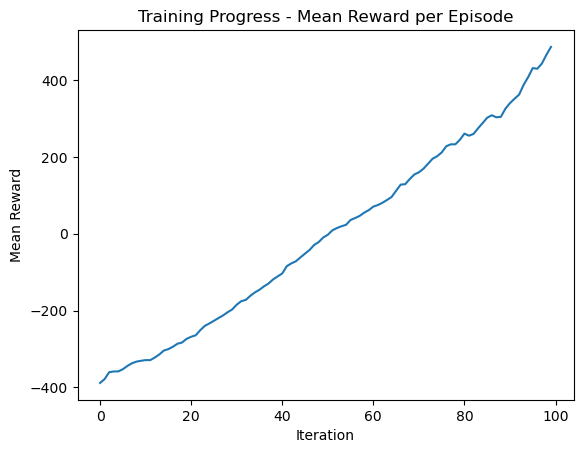

In [142]:
plt.plot(rewards)
plt.title('Training Progress - Mean Reward per Episode')
plt.xlabel('Iteration')
plt.ylabel('Mean Reward')
# plt.savefig('Basic PPO - HalfCheetah-v4')
plt.show()

### MOG and Energy Distance

In [10]:
global adder
adder = 1.000001
global num_gaussians
num_gaussians = 3
global parquet_path
parquet_path = "results/logs/parquet_logs.parquet"

class CustomTorchModelMOG(TorchModelV2, nn.Module):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        super(CustomTorchModelMOG, self).__init__(obs_space, action_space, num_outputs, model_config, name)
        
        TorchModelV2.__init__(self, obs_space, action_space, num_outputs, model_config, name)
        
        nn.Module.__init__(self)
        
        self.actor_fcnet = TorchFC(obs_space, action_space, 2, model_config, name + "_actor")
        
        self.critic_fcnet = TorchFC(obs_space, action_space, num_gaussians*3, model_config, name + "_critic")
        
        self.log_step = 0
        
        self.log_data = pd.DataFrame(columns = ['iteration', 'energy_distance','first_term_logged',
                                                'second_term_logged','erf'])
        '''
        Get the output from fcnet, which is tuple of the new state and the the output of
        the FullyConnectedLayer module under ray.rllib.models.torch.fcnet.py
        -->This output is from the inherited modelv2 from ray.rllib.models.modelv2.py
        ---which consists of outputs from calling self.foward as well as the state_out information
        ---which is the current (next) state
        

        -The input_dict contains complex observations (obs_flat, prev_action, prev_reward, is_training,
        -eps_id, agent_id, infos, and t) which will be unpacked by __call__ in modelv2 before being 
        -passed to the foward pass
        
        -State includes the list of state tensors with sizes matching those returned by get_initial_state
        + the batch dimension
        
        -seq_lens is a 1d tensor holding input sequence lengths
        
        -We can access the flattened observation tensor by input_dict['obs_flat']
        
        **Custom models should override forward and not __call__
        **The forward pass has to be performed before the value function call and calling the value
        function does not cause another call on the forward pass
        
        '''
        
    @OverrideToImplementCustomLogic
    def forward(self, input_dict, state, seq_lens):
        
        action_logits, _ = self.actor_fcnet(input_dict, state, seq_lens)

        value_output, _ = self.critic_fcnet(input_dict, state, seq_lens)
    
        '''
        -value_output is a function of the number of components we wish to have for the MoGs
        --Because of this, it makes sense to have the arrays slice based on the number of components input
          from a user
        '''
        
        elu = torch.nn.ELU()
        
        i = num_gaussians
        means = value_output[:, :i]
        self._u = means
        
        sigmas_prev = value_output[:, i:i*2]
        sigmas = elu(sigmas_prev) + adder
        self._sigmas = sigmas
        
        alphas = value_output[:, i*2:]
        alphas = torch.nn.functional.softmax(alphas, dim=-1)
        self._alphas = alphas

        return action_logits, state

    @OverrideToImplementCustomLogic
    def value_function(self):
        multiply = self._u * self._alphas
        values = torch.sum(multiply, dim = 1)
        return values
    
    '''
    -We need the sample from MoG as a means of doing the n-step return which is common for reducing
    variance, but at the cost of increasing bias...fortunately, betwen 3-7 samples is enough to 
    approximately have the bias/variance tradeoff nearly equal
    --This is important to do to increase convergence and also decrease computation time compared to
    the Monte Carlo approach which is sampling a bunch of trajectories
    
    -From the sample we need to compute the log probabilites of the samples
    '''

    def predict_gmm_params(self, cur_obs):
        input_dict = {'obs': cur_obs}
        state = []  
        seq_lens = None
        value_output, _ = self.critic_fcnet(input_dict, state, seq_lens)
        
#         self.value_ouput_tensor = torch.tensor(value_output, dtype=torch.int)
        # Extract GMM parameters from the critic output
        
        
        elu = torch.nn.ELU()
        
        i = num_gaussians
        means = value_output[:, :i]
        sigmas_prev = value_output[:, i:i*2]
        sigmas = elu(sigmas_prev) + adder
        alphas = value_output[:, i*2:]
        alphas = torch.nn.functional.softmax(alphas, dim=-1)
        
        return means, sigmas, alphas
    
    def generate_target_gmm_params(self, rewards, next_states, dones, gamma=0.99):

        mu_next, sigma_next, w_next = self.predict_gmm_params(next_states)
        mu_target = mu_next + (rewards.unsqueeze(-1) * gamma) * (1 - dones.unsqueeze(-1).float())
        sigma_target = sigma_next
        w_target = w_next
    
        return mu_target.clone().detach(), sigma_target.clone().detach(), w_target.clone().detach()
    
    
    def compute_energy_distance_mog(self, mu_u, sigma_u, w_u, mu_v, sigma_v, w_v):
        """
        Compute the energy distance between three Gaussian Mixture Models (GMMs) analytically,
        including internal dispersion terms.
        """
        N = mu_u.size(0)
        N0 = mu_v.size(0)
        
        
        # Calculate delta(U, V)
        delta_U_V = self.calculate_delta(mu_u, sigma_u, w_u, mu_v, sigma_v, w_v) / N

        # Calculate internal dispersion delta(U, U_0) and delta(V, V_0)
        delta_U_U0 = self.calculate_delta(mu_u, sigma_u, w_u, mu_u, sigma_u, w_u) / N
        delta_V_V0 = self.calculate_delta(mu_v, sigma_v, w_v, mu_v, sigma_v, w_v) / N
        # Compute energy distance
#         energy_distance = delta_U_V
        energy_distance = 2 * delta_U_V - delta_U_U0 - delta_V_V0
        if self.log_step % 1 == 0:
            self.log_to_dataframe(energy_distance = energy_distance, first_term_logged = None,
                                 second_term_logged = None, erf = None)
    
        return energy_distance
    
    def log_to_dataframe(self, energy_distance, first_term_logged, second_term_logged , erf):
        new_log_entry = pd.DataFrame({
            'iteration': [self.log_step],
            'energy_distance': [energy_distance.mean().item() if energy_distance is not None else np.nan],
            'first_term_logged': [first_term_logged.mean().item() if first_term_logged is not None else np.nan],
            'second_term_logged': [second_term_logged.mean().item() if second_term_logged is not None else np.nan],
            'erf': erf.mean().item() if erf is not None else np.nan,
        })
        
        self.log_data = pd.concat([self.log_data, new_log_entry], ignore_index = True)
        
        if self.log_step % 1000 == 0:
            self.save_to_parquet()
        self.log_step += 1
        
    def save_to_parquet(self):
        self.log_data.to_parquet(parquet_path)
        
        
    def calculate_delta(self, mu_1, sigma_1, w_1, mu_2, sigma_2, w_2):
        """
        Compute delta for given GMM parameters.
        """
        mu_1_expanded = mu_1.unsqueeze(2)
        mu_2_expanded = mu_2.unsqueeze(1)

        sigma_1_expanded = sigma_1.unsqueeze(2)
        sigma_2_expanded = sigma_2.unsqueeze(1)

        w_1_expanded = w_1.unsqueeze(2)
        w_2_expanded = w_2.unsqueeze(1) 

        diff_mu = mu_1_expanded - mu_2_expanded

        sum_vars = sigma_1_expanded ** 2 + sigma_2_expanded ** 2
        sum_vars_clamped = torch.clamp(sum_vars, 1e-6, 1e5)
        diff_mus_clamped = torch.clamp(diff_mu, -1.5e5, 2e5)
        exp_term = (-diff_mus_clamped**2) / (2*sum_vars_clamped)

        sqrt_2_over_pi = torch.sqrt(torch.tensor(2) / torch.tensor(math.pi))

        first_term = sqrt_2_over_pi * torch.sqrt(sum_vars_clamped) * torch.exp(exp_term)
        
        erf_term = -diff_mus_clamped / (sum_vars_clamped * torch.sqrt(torch.tensor(2)))
        erf = torch.special.erf(erf_term)
        second_term = diff_mus_clamped * (1 - 2 * erf)

        E_Zij = first_term + second_term

        delta = torch.sum(w_1_expanded * w_2_expanded * E_Zij, dim=(1,2))
        
        if self.log_step % 1 == 0:
            self.log_to_dataframe(energy_distance = None, first_term_logged = first_term, 
                                  second_term_logged = second_term, erf = erf)

        return delta


    @OverrideToImplementCustomLogic
    def custom_loss(self, policy_loss, sample_batch):
        
        cur_obs = sample_batch[SampleBatch.CUR_OBS]
        next_states = sample_batch[SampleBatch.NEXT_OBS]
        rewards = sample_batch[SampleBatch.REWARDS]
        dones = sample_batch[SampleBatch.DONES]

        mu_pred, sigma_pred, w_pred = self.predict_gmm_params(cur_obs)
    
        mu_target, sigma_target, w_target = self.generate_target_gmm_params(rewards, next_states, dones, gamma=0.99)

        energy_distance = self.compute_energy_distance_mog(mu_pred, sigma_pred, w_pred, 
                                                           mu_target, sigma_target, w_target)

        energy_distance_scalar = torch.mean(energy_distance)

        custom_loss_component = 1.0 * energy_distance_scalar
        modified_policy_loss = [loss + custom_loss_component for loss in policy_loss]

        return modified_policy_loss

'''
Fixes:
(1)Target sigmas were not strictly positive: added the elu activation along with a positive constant
(2)Fixed the critic network's sigmas to be elu with an added constant isntead of squares
(3)Added the cdf of the normal distribution (second term) to the loss function as per GMAC's paper
(3->)this fixed the negative distance values that were happening since this should not have happened
(3->)due to the way the expectation is taken between dists will always be positive
(4)Added internal dispersion back into the energy distance once the delta method was fixed with (3) above
(4->)This has an appropriate magnitude for the loss compared to the policy loss so no scaling is needed
(5)The result of the four main points above gives results of 1_000+ in the Cheetah-v4 env. after 100 iterations
(6)Updated file savings from csv logs to parquet logs for better effeciency and control
(7)Clamped the exp term -- after logging this term alone was 800_000_000_000 --
'''


"\nFixes:\n(1)Target sigmas were not strictly positive: added the elu activation along with a positive constant\n(2)Fixed the critic network's sigmas to be elu with an added constant isntead of squares\n(3)Added the cdf of the normal distribution (second term) to the loss function as per GMAC's paper\n(3->)this fixed the negative distance values that were happening since this should not have happened\n(3->)due to the way the expectation is taken between dists will always be positive\n(4)Added internal dispersion back into the energy distance once the delta method was fixed with (3) above\n(4->)This has an appropriate magnitude for the loss compared to the policy loss so no scaling is needed\n(5)The result of the four main points above gives results of 1_000+ in the Cheetah-v4 env. after 100 iterations\n(6)Updated file savings from csv logs to parquet logs for better effeciency and control\n(7)Clamped the exp term -- after logging this term alone was 800_000_000_000 --\n"

In [11]:
ModelCatalog.register_custom_model("custom_torch_model_mog", CustomTorchModelMOG)

In [12]:
config = PPOConfig().training(
    gamma = 0.99,
    lambda_ = 0.95,
    kl_coeff = 0.5,
    num_sgd_iter =32,
    lr= 0.0001, 
    vf_loss_coeff = 1.0,
    vf_clip_param = 1.0,
#     clip_param = 0.2,
    clip_param = 0.4,
    grad_clip_by='norm', 
    train_batch_size=8192, 
    sgd_minibatch_size=2048,
    grad_clip = 1.0,
    model={'custom_model': 'custom_torch_model_mog', 
    'vf_share_layers': False, 'fcnet_hiddens': [256,256],'fcnet_activation': 'silu'}
).environment(env='HalfCheetah-v4'
).rollouts(
num_rollout_workers = 2,
num_envs_per_worker = 4,
)

num_iterations = 500





algo = config.build()
rewards = []

for i in range(num_iterations):
    result = algo.train()
    print(f"Iteration: {i}, Mean Reward: {result['episode_reward_mean']}")
    rewards.append(result['episode_reward_mean'])
    
ray.shutdown()

C:\Users\TylerLaurie\anaconda3\Lib\site-packages\ray\rllib\algorithms\algorithm.py:483: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
C:\Users\TylerLaurie\anaconda3\Lib\site-packages\ray\tune\logger\unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
C:\Users\TylerLaurie\anaconda3\Lib\site-packages\ray\tune\logger\unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray

Iteration: 0, Mean Reward: -418.4787937125414
Iteration: 1, Mean Reward: -403.23346918164316


(pid=25380) C:\Users\TylerLaurie\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
(pid=25380)   "class": algorithms.Blowfish,
(RolloutWorker pid=25380) C:\Users\TylerLaurie\anaconda3\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.single_observation_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.single_observation_space` for environment variables or `env.get_wrapper_attr('single_observation_space')` that will search the reminding wrappers.
(RolloutWorker pid=25380)   logger.warn( [repeated 2x across cluster]
(RolloutWorker pid=25380) C:\Users\TylerLaurie\anaconda3\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.single_action_space to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.single_action_space` for environment variables or

### first tune parameter search for vf_loss_coefficient gave vf_loss_coefficient = 0.5 as the best for 0.1, 0.5, 1.0

In [30]:
import os

In [34]:
path = os.getcwd()
data = pd.read_parquet(path + '\\results\\logs\\parquet_logs.parquet')

In [35]:
data

,iteration,energy_distance,first_term_logged,second_term_logged,erf
0,0,NaN,0.897862,1.375080,-1.731827e-01
1,1,NaN,1.135388,0.000518,4.042199e-12
2,2,NaN,1.135402,0.000519,-1.616879e-12
3,3,0.001110,NaN,NaN,NaN
4,4,NaN,0.955752,0.987540,-9.438251e-02
...,...,...,...,...,...
996,996,NaN,5.799231,0.950175,-5.193989e-03
997,997,NaN,6.127588,0.224950,9.701277e-12
998,998,NaN,6.129006,0.225056,-3.233759e-12
999,999,-0.000003,NaN,NaN,NaN


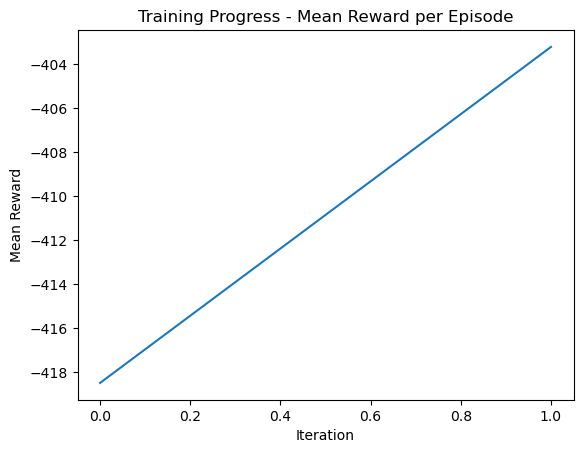

In [37]:
plt.plot(rewards)
plt.title('Training Progress - Mean Reward per Episode')
plt.xlabel('Iteration')
plt.ylabel('Mean Reward')
# plt.savefig('MOG and Energy Distance - HalfCheetah-v4')
plt.show()